In [1]:
# This kernel have improvement from Pranav Pandya and Andy Harless
# Pranav Kernel: https://www.kaggle.com/pranav84/xgboost-on-hist-mode-ip-addresses-dropped
# Andy Kernel: https://www.kaggle.com/aharless/jo-o-s-xgboost-with-memory-usage-enhancements

import gc
import time
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Change this for validation with 10% from train
is_valid = False

path = '../input/'

def timeFeatures(df):
    # Make some new features with click_time column
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['dow']      = df['datetime'].dt.dayofweek
    df["doy"]      = df["datetime"].dt.dayofyear
    #df["dteom"]    = df["datetime"].dt.daysinmonth - df["datetime"].dt.day
    df.drop(['click_time', 'datetime'], axis=1, inplace=True)
    return df

start_time = time.time()

train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

lines = 184903891

#generate list of lines to skip
skiplines = np.random.choice(np.arange(1, lines), size=lines-1-10000000, replace=False)

#sort the list
skiplines=np.sort(skiplines)

# Read the last lines because they are more impacting in training than the starting lines
train = pd.read_csv(path+"train.csv", skiprows=skiplines, nrows=10000000, usecols=train_columns, dtype=dtypes)
# test = pd.read_csv(path+"test_supplement.csv", usecols=test_columns, dtype=dtypes)

print('[{}] Finished to load data'.format(time.time() - start_time))



/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[284.6713180541992] Finished to load data


In [2]:
# Drop the IP and the columns from target
y = train['is_attributed']
train.drop(['is_attributed'], axis=1, inplace=True)

# Drop IP and ID from test rows
sub = pd.DataFrame()
#sub['click_id'] = test['click_id'].astype('int')
gc.collect()

nrow_train = train.shape[0]
# merge = pd.concat([train, test])

# del train, test
gc.collect()

# Count the number of clicks by ip
ip_count = train.groupby(['ip'])['channel'].count().reset_index()
ip_count.columns = ['ip', 'clicks_by_ip']
train = pd.merge(train, ip_count, on='ip', how='left', sort=False)
train['clicks_by_ip'] = train['clicks_by_ip'].astype('uint16')
train.drop('ip', axis=1, inplace=True)

# train = merge[:nrow_train]
# test = merge[nrow_train:]

# del test,d merge
gc.collect()

print('[{}] Start to generate time features'.format(time.time() - start_time))

train = timeFeatures(train)
gc.collect()

[337.91448736190796] Start to generate time features


28

In [3]:
print('[{}] Start XGBoost Training'.format(time.time() - start_time))

# Set the params(this params from Pranav kernel) for xgboost model
params = {'eta': 0.3,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,  
          'max_depth': 0, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':0,
          'alpha':4,
          'objective': 'binary:logistic', 
          'scale_pos_weight':9,
          'eval_metric': 'auc', 
          'nthread':8,
          'random_state': 99, 
          'silent': True}
          

if (is_valid == True):
    # Get 10% of train dataset to use as validation
    x1, x2, y1, y2 = train_test_split(train, y, test_size=0.1, random_state=99)
    dtrain = xgb.DMatrix(x1, y1)
    dvalid = xgb.DMatrix(x2, y2)
    del x1, y1, x2, y2 
    gc.collect()
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    model = xgb.train(params, dtrain, 200, watchlist, maximize=True, early_stopping_rounds = 25, verbose_eval=5)
    del dvalid
else:
    dtrain = xgb.DMatrix(train, y)
    del train, y
    gc.collect()
    watchlist = [(dtrain, 'train')]
    model = xgb.train(params, dtrain, 30, watchlist, maximize=True, verbose_eval=1)

del dtrain
gc.collect()

print('[{}] Finish XGBoost Training'.format(time.time() - start_time))

[351.06504797935486] Start XGBoost Training
[0]	train-auc:0.962154
[1]	train-auc:0.963546
[2]	train-auc:0.964013
[3]	train-auc:0.965328
[4]	train-auc:0.965797
[5]	train-auc:0.966548
[6]	train-auc:0.965755
[7]	train-auc:0.965095
[8]	train-auc:0.965774
[9]	train-auc:0.966607
[10]	train-auc:0.966926
[11]	train-auc:0.969402
[12]	train-auc:0.971357
[13]	train-auc:0.973363
[14]	train-auc:0.97622
[15]	train-auc:0.977645
[16]	train-auc:0.978807
[17]	train-auc:0.980746
[18]	train-auc:0.981409
[19]	train-auc:0.981551
[20]	train-auc:0.981961
[21]	train-auc:0.98284
[22]	train-auc:0.985337
[23]	train-auc:0.986295
[24]	train-auc:0.987761
[25]	train-auc:0.988755
[26]	train-auc:0.990315
[27]	train-auc:0.991372
[28]	train-auc:0.991417
[29]	train-auc:0.991544
[527.1788573265076] Finish XGBoost Training


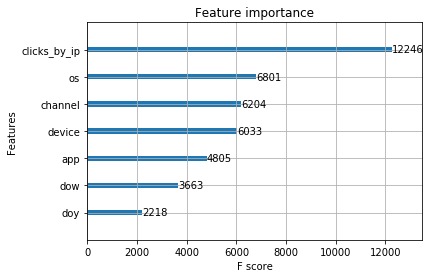

In [4]:
# Plot the feature importance from xgboost
plot_importance(model)
# plt.gcf().savefig('feature_importance_xgb.png')

In [5]:
# Load the test for predict 
test = pd.read_csv(path+"test.csv", usecols=test_columns, dtype=dtypes)
test = pd.merge(test, ip_count, on='ip', how='left', sort=False)
del ip_count
gc.collect()

21

In [13]:
test.describe()

,click_id,ip,app,device,os,channel,clicks_by_ip
count,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.478056e+07
mean,9.395234e+06,6.306921e+04,1.221480e+01,1.730513e+00,1.873312e+01,2.648059e+02,5.380214e+03
std,5.424341e+06,3.688597e+04,1.164924e+01,2.597038e+01,1.135059e+01,1.355254e+02,1.801049e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,4.697617e+06,3.155800e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.350000e+02,1.650000e+02
50%,9.395234e+06,6.393600e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.360000e+02,4.300000e+02
75%,1.409285e+07,9.531600e+04,1.800000e+01,1.000000e+00,1.900000e+01,4.010000e+02,1.390000e+03
max,1.879047e+07,1.264130e+05,5.210000e+02,3.031000e+03,6.040000e+02,4.980000e+02,1.154500e+05


In [6]:
sub['click_id'] = test['click_id'].astype('int')

# test['clicks_by_ip'] = test['clicks_by_ip'].astype('uint16')
test = timeFeatures(test)
test.drop(['click_id', 'ip'], axis=1, inplace=True)
dtest = xgb.DMatrix(test)
del test
gc.collect()

# Save the predictions
sub['is_attributed'] = model.predict(dtest, ntree_limit=model.best_ntree_limit)
sub.to_csv('xgb_sub.csv', float_format='%.8f', index=False)